## Data Visualization & Clustering

## Chapters
- I. Pre Processing from Feature Engineering
- II. Pre Processing for Data Visualization
1. Standardized Data
2. Reduce Dimensions
3. Visualization using Bokeh graph
- III. KNN Clustering
1. Hyperparameter optimization
2. Model implementation with most optimal hyperparemeter

## I. Pre-processing from Feature Engineering

1. Import dataframe
2. Drop variable data, Sector
3. Import one hot encoded data
4. Join dataframes
5. Re-run vectorization on indicator column

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Import Data set but drop variable data and Sector
# Variable - we will cluster with out it since its not normalized
# Sector - has been one hot encoded 
df = pd.read_csv("../data_cleaning/final_data.csv")
df = df.drop(columns=["Data", "Sector"])

# Import One hot encoded columns 
sector_one_hot_encoded = pd.read_csv("../feature-engineering/sector_one_hot_encoded.csv")

# Concatenate df with sector_one_hot_encoded
result_df = pd.concat([df, sector_one_hot_encoded], axis=1)

print(result_df)


                  Variable/Indicator  Sector_EDUCATION  Sector_ENVIRONMENT  \
0                 adult_samehome_nyc               0.0                 0.0   
1                  asian_api_pop_nyc               0.0                 0.0   
2                asian_api_total_nyc               0.0                 0.0   
3       asian_api_pop_nyc_historical               0.0                 0.0   
4           asian_api_pop_change_nyc               0.0                 0.0   
..                               ...               ...                 ...   
343  veterans_unemployed_percent_nyc               0.0                 0.0   
344  unpaid_family_workers_class_nyc               0.0                 0.0   
345             veterans_poverty_nyc               0.0                 0.0   
346     veterans_poverty_percent_nyc               0.0                 0.0   
347     government_workers_class_nyc               0.0                 0.0   

     Sector_FOOD SYSTEMS  Sector_HEALTH  Sector_HOUSING & INFRA

In [26]:
print(df.columns)

Index(['Variable/Indicator'], dtype='object')


In [28]:
# Re-run vectorization on Indicator column as previously seen on feature-engineering
from sklearn.feature_extraction.text import TfidfVectorizer
## Initialize Vectorizer

vectorizer = TfidfVectorizer()

## Fit and Transform Data - Allows the vector to "learn" the variable names
variables_tfidf_matrix = vectorizer.fit_transform(result_df['Variable/Indicator'])

## variables_tfidf_matrix is the variable that holds matrices of learned words that could be directly inserted to our model

## II. Pre Processing for Data Visualization


II.1
tandardize the Data:

High-dimensional datasets often contain features with varying scales. For visualization and many clustering algorithms, it's important to standardize features to have zero mean and unit variance.
python


In [31]:
from sklearn.preprocessing import StandardScaler

# The vectorized text matrix
# variables_tfidf_matrix

# Your one-hot encoded data (excluding the text column)
one_hot_encoded = result_df.drop('Variable/Indicator', axis=1).values

# Initialize the scaler
scaler = StandardScaler()

# Standardize the vectorized text data
text_vector_standardized = scaler.fit_transform(variables_tfidf_matrix.toarray())  # Convert sparse matrix to dense

# Standardize one-hot encoded data
one_hot_encoded_standardized = scaler.fit_transform(one_hot_encoded)

# Combine standardized data
standard_final_data = np.concatenate([text_vector_standardized, one_hot_encoded_standardized], axis=1)


In [39]:
print(standard_final_data)

[[-0.05368281 -0.05368281 18.62793601 ... -0.19699231 -0.2597781
  -0.42386439]
 [-0.05368281 -0.05368281 -0.05368281 ... -0.19699231 -0.2597781
  -0.42386439]
 [-0.05368281 -0.05368281 -0.05368281 ... -0.19699231 -0.2597781
  -0.42386439]
 ...
 [-0.05368281 -0.05368281 -0.05368281 ... -0.19699231 -0.2597781
   2.35924516]
 [-0.05368281 -0.05368281 -0.05368281 ... -0.19699231 -0.2597781
   2.35924516]
 [-0.05368281 -0.05368281 -0.05368281 ... -0.19699231 -0.2597781
   2.35924516]]


II.2 Reduce Dimensions using t-SNE

Dimensionality reduction is an essential step in data    processing and machine learning for several reasons:
1. Visualization: One of the most immediate benefits of reducing dimensionality is the ability to visualize data. 

2. Noise Reduction: Dimensionality reduction techniques, especially when linear methods like PCA are used, can help remove noise from the data.

3. Avoid Overfitting: High-dimensional datasets with a limited number of samples can lead to overfitting in machine learning models, where the model learns the noise in the training data instead of the underlying pattern. 

REDUCING DIMENSIONS USING t-SNE

We use t-SNE because, 

Categorical Nature of Data: PCA works best with continuous data since it seeks to maximize variance. Given that a significant portion of your data (especially the Variable/Indicator column) is categorical in nature (even after being transformed using TF-IDF), t-SNE might offer better visual separations.

In [33]:
from sklearn.manifold import TSNE

# Assuming you've standardized your data and it's stored in `standard_final_data`

# Apply t-SNE. You can adjust the parameters as needed.
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(standard_final_data)


II.3 Visualization with Bokeh Graph
Bokeh is a powerful visualization tool that can help create interactive plots. Here's how to visualize the t-SNE results using Bokeh:

In [35]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.io import push_notebook
from bokeh.models import HoverTool, ColumnDataSource


# Convert the t-SNE results into a DataFrame for easier handling
df_tsne = pd.DataFrame(tsne_results, columns=['x', 'y'])

# Create a Bokeh data source
source = ColumnDataSource(data=df_tsne)

# Initialize Bokeh plot
p = figure(width=800, height=800, title="t-SNE visualization")
p.scatter(x='x', y='y', source=source, alpha=0.6)

# Hover tool to show index of data point
hover = HoverTool()
hover.tooltips = [("index", "$index")]
p.add_tools(hover)

# Show plot in notebook
output_notebook()
show(p, notebook_handle=True)

Loading BokehJS ...

## FINDINGS
So far the cluster that was reduced using tsne did not really cluster so well, there are a few points that gathered together but overall the data does not really tell us anyhting.

## III. Clustering with K-means

Our use case where you want to identify distinct groups of variables based on the presence of certain words and their respective coding schemes, k-means clustering is a suitable and commonly used method. It partitions the dataset into k mutually exclusive clusters, where each data point belongs to the cluster with the nearest mean.


III.I Determine Optimal number of Clusters(k) / Hyperparameter Optimization

- Elbow Method: This involves plotting the cost (sum of squared distances to the nearest cluster center) against the number of clusters. The "elbow" point, where the rate of decrease sharply changes, indicates an optimal number for clusters.

- Silhouette Score: Measures how close each point in one cluster is to the points in the neighboring clusters. Values range between -1 and 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters

In [43]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings

# Suppress FutureWarnings. If removed terminal will return an error each time the loop iterates
warnings.simplefilter(action='ignore', category=FutureWarning)

costs = []
silhouette_scores = []
range_clusters = range(2, 15)  # Adjust range as needed

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(standard_final_data)
    
    # Cost (inertia) - sum of squared distances to nearest cluster center
    costs.append(kmeans.inertia_)
    
    # Silhouette Score
    silhouette_avg = silhouette_score(standard_final_data, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)



Visualize results of clustering to find best hyperparameter

Elbow Method Using Inertia (Cost)

The inertia measures how far points in a cluster are from the center of that cluster. Ideally, you want a lower inertia, but the rate of decrease sharply changes at some point, creating an "elbow" in the graph. The number of clusters where this change becomes noticeable can be considered a good estimate for the actual number of clusters.
Silhouette Score

Silhouette score gives a perspective into the density and separation of the formed clusters. Higher silhouette scores mean that the clusters are well apart from each other and clearly distinguished. Values range from -1 to 1. A high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

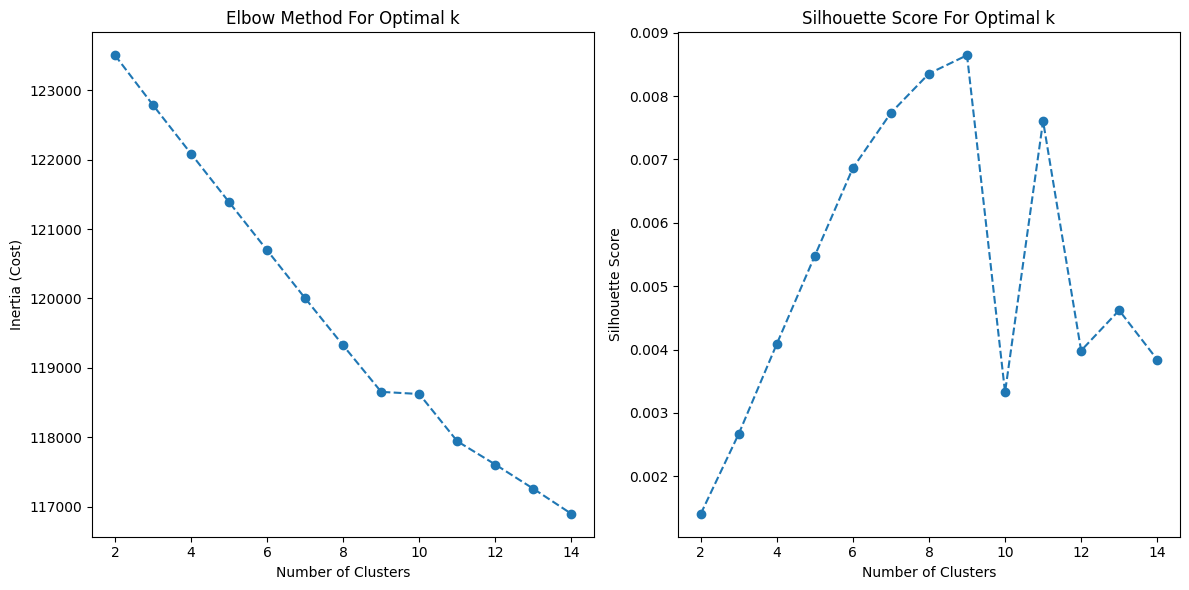

In [44]:
# Plot the costs and silhouette scores
import matplotlib.pyplot as plt

# Plotting the costs (Elbow Method)
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(range_clusters, costs, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Cost)')

# Plotting the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(range_clusters, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()


## Interpretation

Elbow Method For Optimal k (Inertia/Cost)

- The inertia starts off relatively high and decreases as the number of clusters increases. The steepest decline seems to be up until around 6-7 clusters, after which the decline starts to level off. This "elbow" point suggests that adding more clusters beyond this point results in diminishing returns in terms of reducing inertia.
Silhouette Score For Optimal k

- The silhouette score starts off at a lower value, peaks around 6 clusters, and then begins to drop. A higher silhouette score indicates that the data points are closer to the centers of their respective clusters and farther from the centers of the other clusters. This suggests that the clustering is well-defined. The peak at 6 clusters indicates the optimal clustering in terms of silhouette score.
Interpretation:

Both the Elbow method and the Silhouette score seem to suggest that 6 clusters might be the optimal number for your dataset. This is because the elbow method shows a diminishing rate of decrease in inertia around 6-7 clusters, and the silhouette score peaks at 6 clusters.

It's worth noting that after 6 clusters, the silhouette score decreases sharply, indicating that adding more clusters beyond this might not be beneficial in terms of cluster quality.

## FIT MODEL WITH MOST OPTIMAL HYPERPARAMETERS

In [45]:
optimal_kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = optimal_kmeans.fit_predict(standard_final_data)


In [47]:
# Convert standard_final_data back to a dataframe, so we can join it with cluster
# it was converted to a numpy array for optimization and accuracy purposes
standard_final_data_df = pd.DataFrame(standard_final_data)
standard_final_data_df['Cluster'] = cluster_labels

In [49]:
# Ensure matching length
print(len(cluster_labels))
print(len(standard_final_data))


348
348


In [50]:
print(standard_final_data_df)

            0         1          2         3         4         5         6  \
0   -0.053683 -0.053683  18.627936 -0.053683 -0.053683 -0.053683 -0.053683   
1   -0.053683 -0.053683  -0.053683 -0.053683 -0.053683 -0.053683 -0.053683   
2   -0.053683 -0.053683  -0.053683 -0.053683 -0.053683 -0.053683 -0.053683   
3   -0.053683 -0.053683  -0.053683 -0.053683 -0.053683 -0.053683 -0.053683   
4   -0.053683 -0.053683  -0.053683 -0.053683 -0.053683 -0.053683 -0.053683   
..        ...       ...        ...       ...       ...       ...       ...   
343 -0.053683 -0.053683  -0.053683 -0.053683 -0.053683 -0.053683 -0.053683   
344 -0.053683 -0.053683  -0.053683 -0.053683 -0.053683 -0.053683 -0.053683   
345 -0.053683 -0.053683  -0.053683 -0.053683 -0.053683 -0.053683 -0.053683   
346 -0.053683 -0.053683  -0.053683 -0.053683 -0.053683 -0.053683 -0.053683   
347 -0.053683 -0.053683  -0.053683 -0.053683 -0.053683 -0.053683 -0.053683   

            7         8         9  ...       348       349     

t-SNE to compute low-dimensional reperesentation of high-dimensional data. The same as previously attempted

In [ ]:
from sklearn.manifold import TSNE

clustered_tsne = TSNE(n_components=2, random_state=42)
clustered_tsne_results = tsne.fit_transform(standard_final_data.drop('Cluster', axis=1))


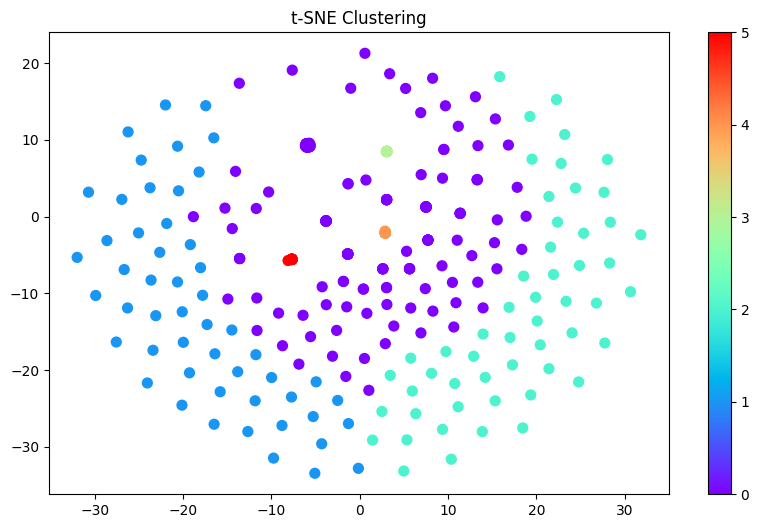

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=standard_final_data_df['Cluster'], cmap='rainbow', s=50)
plt.title('t-SNE Clustering')
plt.colorbar(scatter)
plt.show()


# Interpretation
1. Interpretation of the t-SNE Visualization:

- Clusters: From the t-SNE plot, we see distinct clusters represented by different colors. Some clusters are quite distinct (like the red one), while others are close to each other, suggesting that data points in those clusters might have similar characteristics in the original high-dimensional space.

- Density and Spread: The majority of the data points (in blue) seem to form a more densely packed cluster. This indicates that a large portion of your data has similar characteristics. The scattered points in other colors represent data that's distinct from the main cluster in some way.

- Outliers: The red point stands out and appears to be an outlier or a unique data point that's very different from the others in the dataset.

2. About the Colors and Columns:

- The colors in the t-SNE plot represent the different clusters (groups) identified by the KMeans algorithm, not the individual columns of your dataset. You specified n_clusters=6 in your KMeans algorithm, which means KMeans attempted to partition your data into 6 clusters. The t-SNE visualization then plots the data in 2D space, coloring each data point based on its assigned cluster.

- The t-SNE algorithm reduces the dimensionality of your data for visualization, but it doesn't show individual columns or features. Instead, it gives a visual representation of how similar (or dissimilar) data points are to each other based on all the columns (features) in your dataset.

- In essence, t-SNE takes all the 9 (or 8 after deletion) columns into account to plot each point but doesn't display individual columns in the visualization. The colors simply represent the cluster assignment for each data poin

# We started out with 10 categories why do we only have 6 left?
By selecting 6 as the optimal number of clusters, we've aimed to capture the primary patterns within the data. Choosing a higher number could have resulted in overly specific clusters that might not offer distinct insights. On the other hand, a smaller number would have combined unique groups, potentially oversimplifying the data's complexity. Therefore, with 6 clusters, some smaller groupings might have been integrated into larger, more dominant clusters. So, if we consider a scenario where a data point originally belonged to a now-merged cluster, any recommendations or interpretations based on that data point would align with its new, broader cluster.